In [45]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering
### Associated lectures: Lectures 15 and 16

**Due date: Check the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html)**

## Imports <a name="im"></a>

In [46]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import sentence_transformers
import pyarrow 
import pyarrow.parquet

from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from wordcloud import WordCloud

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:6}

**Please be aware that this homework assignment requires installation of several packages in your course environment. It's possible that you'll encounter installation challenges, which might be frustrating. However, remember that solving these issues is not wasting time but it is an essential skill for anyone aspiring to work in data science or machine learning.**

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 4. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb. If the pdf or html also fail to render on Gradescope, please create two files for your homework: hw6a.ipynb with Exercise 1 and hw6b.ipynb with Exercises 2 and 3 and submit these two files in your submission.  
</div>

_Points:_ 6

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise you will cluster sentences from a toy corpus. Later in the homework you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [3]:
import nltk

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "baguette food",
    "banana bread food",
    "bread food",
    "data science",
    "sports analytics",
    "football sport",
    "ice hockey",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    text = sent_tokenize(wikipedia.page(queries[i]).content)[1]
    wiki_dict["text"].append(text)
    wiki_dict["n_words"].append(len(word_tokenize(text)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
display(wiki_df)

,wiki query,text,n_words
0,baguette food,It is distinguishable by its length and crisp crust.,10
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17
6,ice hockey,It belongs to a family of sports called hockey.,10


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 
rubric={points}


**Your tasks:**

1. If you are asked to cluster the documents from this toy corpus manually, how many clusters would you identify and how would you label each cluster?   

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 1

I would manually sort the documents into 4 clusters: restaurants (baguette food), food(banana bread food, bread food), data science(data science, sports analytics), and sports(football sport, ice hockey). 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 `KMeans` with bag-of-words representation 
rubric={points}

In the lecture, we saw that data representation plays a crucial role in clustering. Changing flattened representation of images to feature vectors extracted from pre-trained models greatly improved the quality of clustering. 

What kind of representation is suitable for text data? We have used bag-of-words representation to numerically encode text data before, where each document is represented with a vector of word frequencies. 

Let's try clustering documents with this simplistic representation.  

**Your tasks:**

1. Create bag-of-words representation using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with default arguments for the `text` column in `wiki_df` above.
2. Cluster the encoded documents with [`KMeans` clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Use `random_state=42` (for reproducibility) and set `n_clusters` to the number you identified in the previous exercise.
3. Store the clustering labels in `kmeans_bow_labels` variable below. 

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

In [5]:
vectorizer = CountVectorizer()
bagOfWords = vectorizer.fit_transform(wiki_df['text'])
print(sorted(vectorizer.vocabulary_))

['2011', 'ability', 'also', 'an', 'analytics', 'and', 'application', 'are', 'around', 'been', 'belongs', 'bread', 'but', 'by', 'called', 'competitive', 'crisp', 'crust', 'culture', 'cultures', 'data', 'diet', 'distinguishable', 'domain', 'family', 'film', 'following', 'from', 'has', 'history', 'hockey', 'important', 'improve', 'in', 'information', 'integrates', 'is', 'it', 'its', 'knowledge', 'length', 'mainstream', 'maintain', 'many', 'medicine', 'moist', 'moneyball', 'natural', 'of', 'often', 'or', 'organized', 'part', 'physical', 'popularized', 'quick', 'raised', 'recipes', 'recorded', 'release', 'science', 'sciences', 'skills', 'some', 'sports', 'sweet', 'technology', 'term', 'the', 'throughout', 'to', 'underlying', 'use', 'was', 'world', 'yeast']


In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(bagOfWords)
kmeans_bow_labels = kmeans.labels_

In [7]:
wiki_df["bow_kmeans"] = kmeans_bow_labels
display(wiki_df)

,wiki query,text,n_words,bow_kmeans
0,baguette food,It is distinguishable by its length and crisp crust.,10,1
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,3
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1
6,ice hockey,It belongs to a family of sports called hockey.,10,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Sentence embedding representation
rubric={points}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer and more expressive representations of text which can be extracted using transfer learning. In this lab, we will use one such representation called sentence embedding representation, which uses deep learning models to generate dense, fixed-length vector representations for sentences. We will extract such representations using sentence transformer package. Sentence embedding takes into account context of words and semantic meaning of sentences and it is likely to work better when we are interested in clustering sentences based on their semantic similarity. 

```
conda activate cpsc330
conda install pytorch::pytorch torchvision torchaudio -c pytorch
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus. 
2. Cluster documents in our toy corpus encoded with this representation (`emb_sents`) and `KMeans` with following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the clustering labels in `kmeans_emb_labels` variable below. 

In [8]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

# If this cell gives an error, try updating transformers with
# pip install transformers -U

In [9]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.186268,0.286701,0.058714,0.095216,-0.136911,0.091687,-0.029694,-0.104941,0.174888,0.482772,...,0.025579,-0.078821,0.470531,-0.209694,-0.379226,0.409230,-0.299176,0.155533,0.309284,0.124819
1,-0.202058,0.320748,0.190347,0.232200,0.600542,0.376622,-0.018205,-0.027148,-0.076680,0.381883,...,0.213062,-0.080009,0.422756,0.072725,0.016024,-0.014596,-0.202858,-0.162947,-0.190418,-0.002013
2,-0.022417,0.217160,0.022694,0.003616,0.240856,0.358046,-0.053310,-0.328075,0.190012,0.244470,...,0.265412,-0.415595,0.003037,0.052484,0.345947,0.110091,0.405441,0.197792,-0.058254,0.212376
3,0.270839,0.187923,-0.010779,0.318688,-0.092012,-0.204805,0.038100,-0.117648,0.084057,-0.170613,...,0.069944,-0.222987,0.092472,0.309445,0.289248,0.021023,-0.032693,-0.624041,0.358924,-0.034092
4,-0.101732,-0.185133,-0.107289,0.148191,0.458463,-0.555427,-0.073999,0.001754,-0.172459,-0.072560,...,0.428589,-0.340837,-0.159757,0.388600,0.316263,0.090864,-0.162353,-0.225394,0.417016,-0.179008
5,0.124750,0.327760,0.287334,-0.108246,0.024023,-0.123068,0.256753,-0.186897,0.207025,0.225442,...,0.476354,-0.425226,0.153235,0.176923,0.036421,0.104009,-0.137497,0.265885,0.431444,0.173652
6,0.108901,0.087363,0.119847,-0.050133,0.240210,-0.082101,0.190988,0.436202,-0.085557,-0.012787,...,0.145414,0.160033,0.071930,0.147640,0.043789,0.253031,-0.009358,0.415206,0.142142,0.130365


<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 3

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(emb_sents)

KMeans(n_clusters=4, random_state=42)

In [11]:
kmeans_emb_labels = kmeans.labels_

In [12]:
wiki_df["emb_kmeans"] = kmeans_emb_labels
display(wiki_df)

,wiki query,text,n_words,bow_kmeans,emb_kmeans
0,baguette food,It is distinguishable by its length and crisp crust.,10,1,2
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2,2
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0,0
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1,1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,3,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1,3
6,ice hockey,It belongs to a family of sports called hockey.,10,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with cosine distance  
rubric={points}

Now try [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text data, [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work well. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$


**Your tasks**

1. Cluster documents in our toy corpus encoded with sentence embedding representation (`emb_sents`) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan#sklearn.cluster.DBSCAN) with `metric='cosine'`. You will have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values of these hyperparameters are unlikely to work well on this toy dataset.
2. Store the clustering labels in the `dbscan_emb_labels` variable below. 

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [13]:
dbscan = DBSCAN(eps=0.7, min_samples=1, metric='cosine')

In [14]:
dbscan_emb_labels = dbscan.fit_predict(emb_sents)

In [15]:
wiki_df["emb_dbscan"] = dbscan_emb_labels
display(wiki_df)

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan
0,baguette food,It is distinguishable by its length and crisp crust.,10,1,2,0
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2,2,0
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0,0,1
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1,1,2
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,3,1,3
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1,3,4
6,ice hockey,It belongs to a family of sports called hockey.,10,1,1,3


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Hierarchical clustering with sentence embedding representation
rubric={points}

**Your tasks:**

Try hierarchical clustering on `emb_sents`. In particular
1. Create and show a dendrogram with `complete` linkage and `metric='cosine'` on this toy dataset.
2. Create flat clusters using `fcluster` with appropriate hyperparameters and store cluster labels to `hier_emb_labels` variable below.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 3

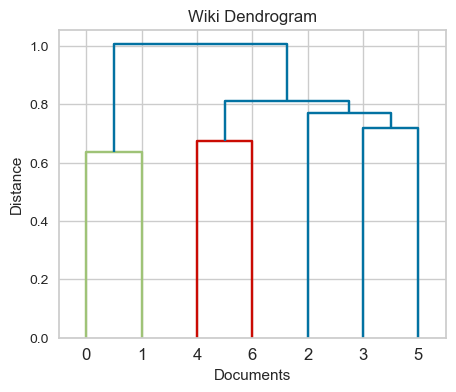

In [16]:
linked = linkage(emb_sents, method='complete', metric='cosine')

plt.figure(figsize=(5, 4))
dendrogram(linked)

plt.title('Wiki Dendrogram')
plt.xlabel('Documents')
plt.ylabel('Distance')
plt.show()

In [17]:
#hier_emb_labels = fcluster(linked, 0.7, criterion='distance')

In [18]:
hier_emb_labels = fcluster(linked, 4, criterion="maxclust") 

In [19]:
wiki_df["emb_hierarchical"] = hier_emb_labels
display(wiki_df)

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan,emb_hierarchical
0,baguette food,It is distinguishable by its length and crisp crust.,10,1,2,0,1
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2,2,0,1
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0,0,1,4
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1,1,2,3
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,3,1,3,2
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1,3,4,3
6,ice hockey,It belongs to a family of sports called hockey.,10,1,1,3,2


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Discussion
rubric={points}

**Your tasks:**

1. Reflect on and discuss the clustering results of the methods you explored in the previous exercises, focusing on the following points:    
    - effect of input representation on clustering results
    - whether the clustering results match with your intuitions and the challenges associated with getting the desired clustering results with each method

<div class="alert alert-warning">

Solution_1.6
    
</div>

_Points:_ 4

    Starting with manually, clustering is left up to interpretation and perhaps could be difficult to reproduce (depending on the data scientist’s interpretation/perspective) and obviously tedious and impossible with larger data sets. However, for very small ones, could be more accurate and specific. I manually selected 4 clusters. 

    For bag of words KMeans, using my 4 cluster selection, it seems to have lumped banana bread food, data science, football, and ice hockey together. Baguette food, bread food, and sports analytics were put in individual clusters. This was not very successful. We did not remove English stop words but since we have such little text to work with in our toy data set, it would just harm the cluster relationships. Bag of words would probably work best with large data sets.
    
    Incorporating semantic similarity in Embedded KMeans helped improve cluster relationships. Baguette food and banana bread food were lumped together, but bread was missed, probably due to the text mentioning history and culture. It lumped data science, sports analytics, and ice hockey together, while missing football. If text is not simplistic and tends to go off on a tangent, in terms of an atypical aspect like the culture of bread, embedding may not be successful enough to capture these nuances. 
    
    Introducing calculus measures with DBScan with cosine distance typically helps get rid of noise by accounting for high dimensionalilty. However, with this small data set, it may be too precise of a tool when looking for small relationships. It took a lot of fine tuning to get cluster information with this model. I was able to get the best average separation (between no relationship and all separate clusters), with 0.7 eps and 1 min sample. The only relationship it found was a cluster including sports analytics and ice hockey. 
    
    The dendrogram was the most fruitful and visual model; at the highest level it correctly separated food topics from sports and data. It found the nuanced relationship of banana bread and bread having a closer relationship than baguette which talked about restaurants, but at a higher level, connected all three. These results make sense as the dendrogram is iterative and includes calculus in its algorithm, leading to more precise results. 
    
    The flat cluster model did not perform well according to distance, but with maxclust it worked much more successfully. Once I set to 4 clusters, it grouped the clusters with similar success to the dendogram model . 


<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 1.7 Visualizing clusters
rubric={points:4}


One approach to working with unlabeled data is visualization. That said, our data is high-dimensional, making it challenging to visualize. Take sentence embedding representation as an example: each instance is depicted in 768 dimensions. To visualize such high-dimensional data, we can employ dimensionality reduction techniques to extract the most significant 2 or 3 components, and then visualize this low-dimensional data.

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```
or

```
> conda activate cpsc330
> pip install umap-learn 
```

If you get an error with the import below try

```
pip install --upgrade numba umap-learn
```

**Your tasks:**

1. Visualize the clusters created by the methods above using `plot_umap_clusters` function below. In other words, visualize clusters identified by each of the methods below. 
    - K-Means with bag-of-words representation 
    - K-Means with sentence embedding representation
    - DBSCAN with sentence embedding representation 
    - Flat cluster of hierarchical clustering with sentence embedding representation     

In [20]:
import umap

In [21]:
def plot_umap_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
    ignore_noise=False,
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    if ignore_noise:
        umap_df = umap_df[umap_df["cluster"] != -1]

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        #edgecolors="k",
        #linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    if show_labels:
        x = umap_df["dim1"].tolist()
        y = umap_df["dim2"].tolist()
        for i, txt in enumerate(raw_sents):
            ax.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
    plt.show()

<div class="alert alert-warning">

Solution_1.7
    
</div>

_Points:_ 4

C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


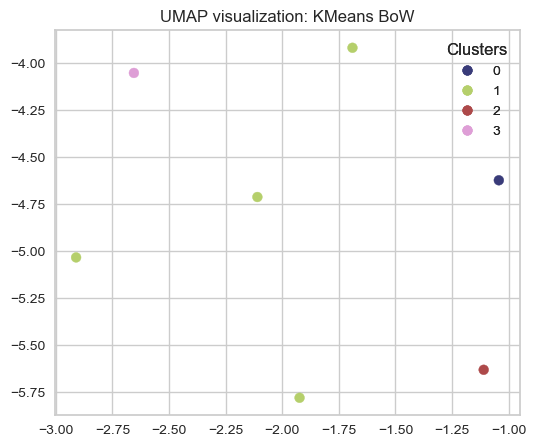

C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


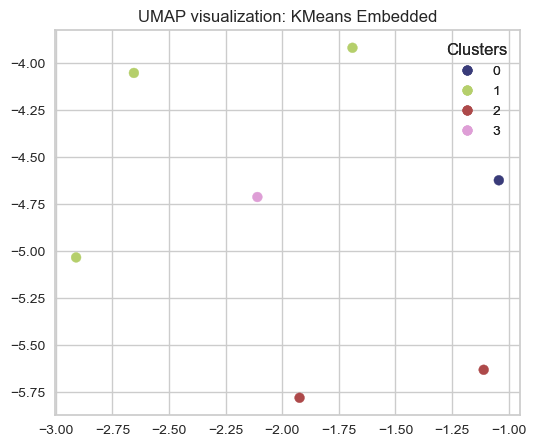

C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


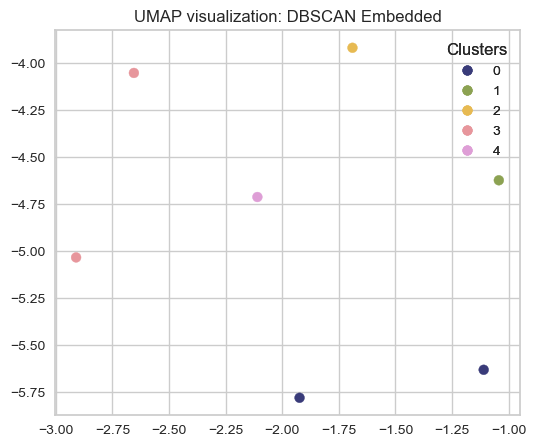

C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\natal\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


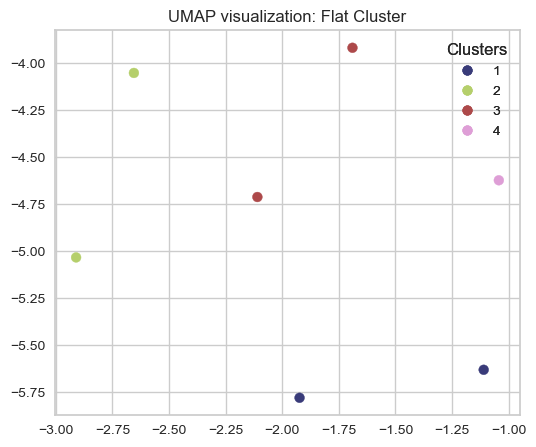

In [22]:
labels = {
    "UMAP visualization: KMeans BoW": kmeans_bow_labels,
    "UMAP visualization: KMeans Embedded": kmeans_emb_labels,
    "UMAP visualization: DBSCAN Embedded": dbscan_emb_labels,
    "UMAP visualization: Flat Cluster": hier_emb_labels
}

for title, label in labels.items():
    title = title
    
    plot_umap_clusters(
        emb_sents,
        label,
        raw_sents=wiki_df["text"],
        show_labels=False,
        size=50,
        n_neighbors=15,
        title=title,
        ignore_noise=False,
    )

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: [Food.com](https://www.food.com/) recipes 
<hr>

Now that we have applied document clustering on a toy corpus, let's move to a more realistic corpus. 

In the lecture, we worked on an activity of manually clustering food items and discussed challenges associated with it. We also applied different clustering algorithms to cluster food images. We'll continue this theme of clustering food items in this lab. But instead of images we will cluster textual description of food items, i.e., recipe names.   

In this lab, we will work with a sample of [Kaggle's Food.com recipes corpus](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this lab, we'll only focus on recipes and **not** on reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find categories or groupings of recipes from this corpus based on their names. 

**Your tasks:**

- Download [`RAW_recipes.csv`](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv) and put it under the `data` directory in the homework folder. 
- Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function `get_recipes_sample` below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags. 

> *Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for `n_tags`. If you decide to go with a different value of `n_tags`, state it clearly in Exercise 2.1 so that the grader knows about it.* 

In [23]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv", encoding='utf-8')
orig_recipes_df.shape

(231637, 12)

In [24]:
def get_recipes_sample(orig_recipes_df, n_tags=1000, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [25]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(14162, 12)

In [26]:
display(recipes_df["name"])

42        i yam what i yam  muffins        
101       to your health  muffins          
128       250 chocolate chip cookies recipe
129       250 00 chocolate chip cookies    
138       lplermagronen                    
              ...                          
231539    zucchini parmesan pancakes       
231547    zucchini salsa burgers           
231596    zuppa toscana                    
231615    zuvers barbecue sauce            
231629    zydeco salad                     
Name: name, Length: 14162, dtype: object

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Longest and shorter recipe names 
rubric={points:2}

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** of them in `shortest_recipe` and/or `longest_recipe` as a **string**.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [27]:
shortest_recipe = min(recipes_df["name"], key=len)
longest_recipe = max(recipes_df["name"], key=len)

display(shortest_recipe)
display(longest_recipe)

'atole'

'baked brie stuffed with strawberry preserves and toasted almonds'

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment.
```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

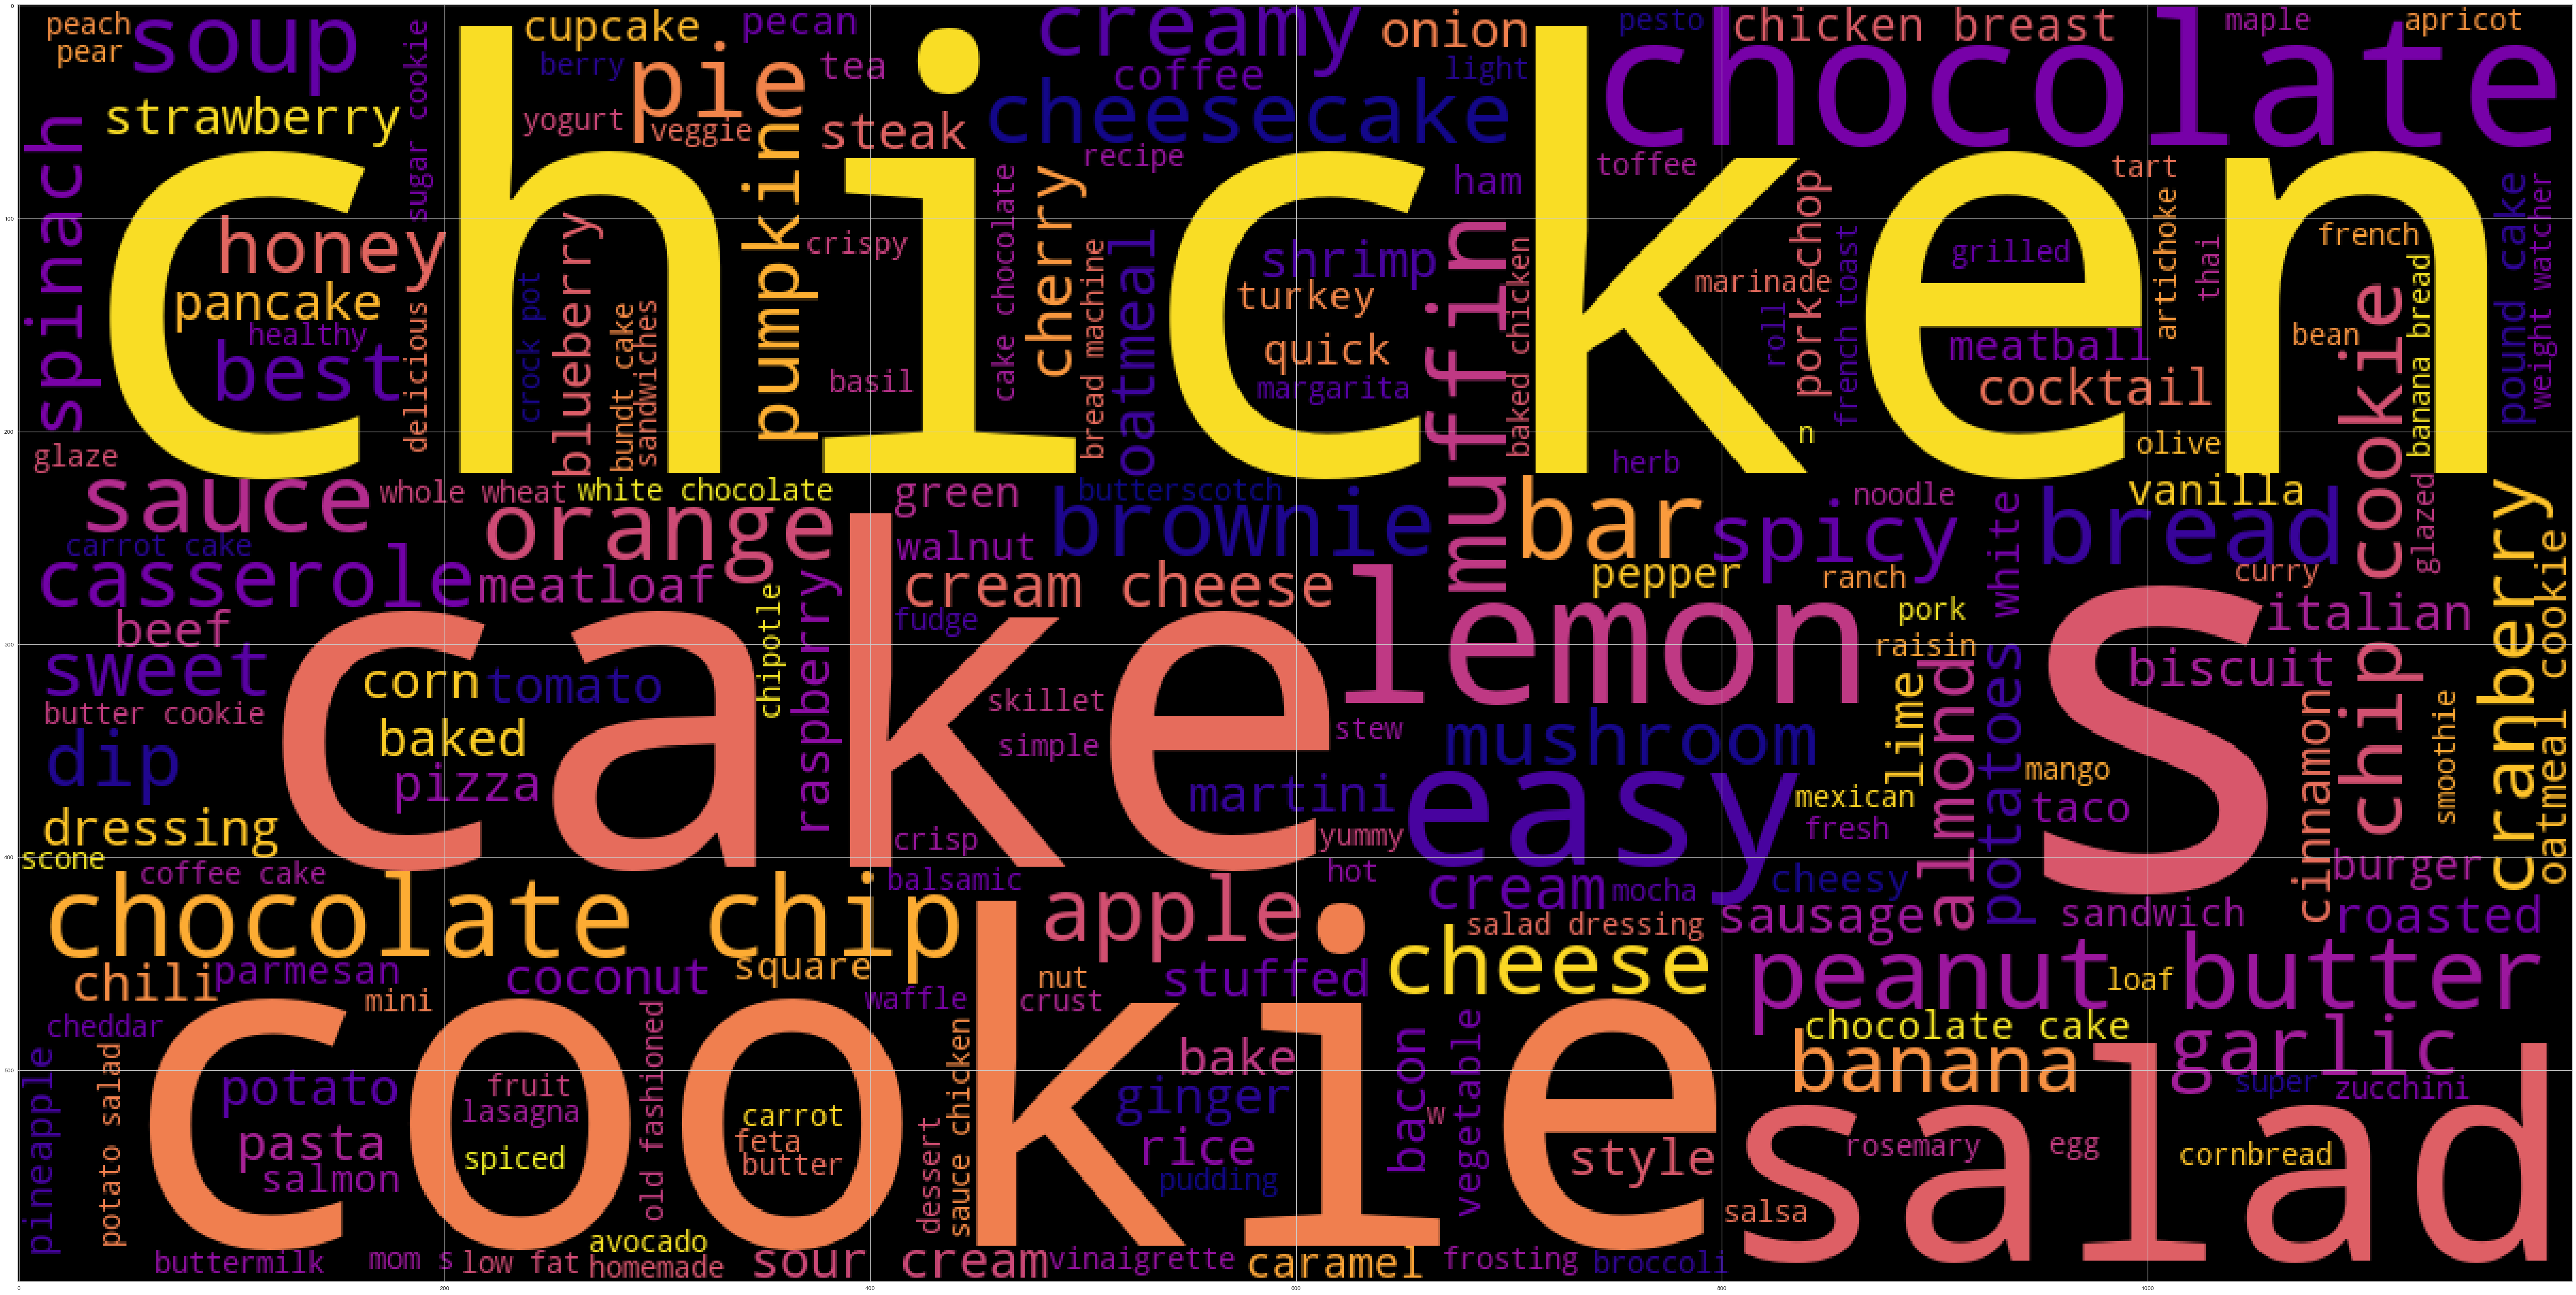

In [28]:
recipesForWordCloud = " ".join(recipes_df["name"].astype(str))

wordCloud = WordCloud(width=1200, height=600, background_color='black', colormap='plasma').generate(recipesForWordCloud)
plt.figure(figsize=(80, 40))
plt.imshow(wordCloud)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Representing recipe names
rubric={points:3}

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.


> You might have to convert the recipe names to a list (`recipes_df["name"].tolist()`) for the embedder to work
> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> **This might take a while to run.**


<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 3

In [29]:
recipeList = recipes_df["name"].tolist()
embeddings = SentenceTransformer("paraphrase-distilroberta-base-v1")
embeddedSent = embeddings.encode(recipeList)
embeddedSent_df = pd.DataFrame(embeddedSent, index=recipes_df.index)
display(embeddedSent_df)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
42,-0.333474,0.227865,-0.307339,0.410549,0.917103,-0.345506,0.305811,0.256676,-0.147712,0.040728,...,-0.053025,-0.209463,0.362418,-0.246085,0.208379,-0.024874,0.506561,0.197739,-0.386421,-0.002184
101,-0.024523,0.246223,-0.055709,0.358273,0.454786,-0.088054,0.260369,0.231947,0.093013,-0.007835,...,0.144860,-0.435460,0.208344,-0.002655,-0.081200,-0.130489,0.452378,0.186310,-0.278500,0.028580
128,0.029670,0.053190,-0.053991,-0.045817,0.956026,-0.188288,0.071061,-0.025920,-0.167691,0.169709,...,0.023293,0.216612,0.200753,0.271870,-0.023339,0.037475,-0.341244,0.155271,-0.170018,0.012112
129,-0.026562,0.194671,0.038101,-0.099181,0.653784,-0.230868,0.064517,0.001376,-0.061280,0.232094,...,0.169605,0.239355,0.392649,0.271398,-0.093971,0.060101,-0.281418,0.133210,-0.122344,-0.109863
138,-0.168002,-0.219218,0.330761,0.302196,-0.173169,0.204557,0.192390,0.140976,0.303174,0.038062,...,0.019094,-0.002447,0.437832,0.563785,0.033442,0.187658,0.529252,-0.233787,0.509931,0.410714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231539,0.032241,0.358776,0.035928,0.159230,0.446190,0.005988,-0.120629,-0.011145,-0.200737,-0.138867,...,0.129480,-0.087242,0.571369,-0.039195,0.228917,0.307089,0.014226,-0.536662,-0.086178,0.022649
231547,0.016149,-0.053035,-0.035097,-0.021836,0.735161,0.245519,-0.151837,0.003955,0.102566,0.001362,...,0.102296,0.023821,0.602686,-0.067071,0.177534,0.253982,0.242439,-0.436000,-0.053910,0.012423
231596,0.026659,0.202482,0.344634,-0.138708,0.514424,0.630948,-0.003165,-0.102897,-0.434900,-0.192056,...,-0.162457,0.130696,0.113645,0.186651,-0.155393,0.130507,1.146238,-0.240861,0.236831,0.177123
231615,0.140687,-0.218252,-0.230094,-0.359361,0.242314,0.108373,-0.072707,0.346143,-0.026216,0.022497,...,0.567123,-0.017117,0.024793,-0.048090,0.158411,0.287006,0.123452,0.713102,-0.243768,0.409292


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 3: Clustering recipe names
<hr>

In this exercise you'll cluster recipe names with some of the clustering algorithms we have seen in class. This will also involve making some attempts to pick reasonable hyperparameter values for each clustering method based on the quality of the resulting clusters. For example, for KMeans, you need to specify the number of clusters in advance, which is often challenging on real-world datasets. For DBSCAN, you need to pick appropriate `eps` and `min_samples`. For hierarchical clustering, you need to pick a suitable linkage criterion, distance metric, and prune the tree so that it's possible to visualize and interpret it. 

Here are some methods which may help you with picking reasonable values for the hyperparameters. 
- Visualize the Elbow plot (KMeans). 
- Visualize Silhouette plots. 
- Visualize resulting clusters using `plot_umap_clusters` function from Exercise 1. 
- Sample some recipes from each cluster, manually inspect whether there are coherent semantic themes. (For this, you may use the function `print_clusters` given below.) 
        
> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot and the Silhouette plots. You can intall it with

```conda install -c districtdatalabs yellowbrick```

**Note that the process of picking reasonable hyperparameter values will be exploratory, iterative, and will involve manual inspection and judgment, as there is no ground truth to verify how well the model is doing. In your solutions, please do not include everything you try. Only present the results of the most informative trials. Add a narrative to your answer so that it's easy for the grader to follow your choices and reasoning.** 

In [30]:
def print_clusters(recipes_df, cluster_labels, n_recipes=10, replace=False, random_state=None):
    """
    Given recipes_df containing recipe names and cluster assignment (labels), 
    sample and print n_recipes recipes per cluster. 

    Parameters
    -----------
    recipe_df : pandas dataframe 
        recipes dataframe containing recipe names in the "name" column
    cluster_labels : ndarray or a list
        cluster labels for each row in recipes_df 
    n_recipes : int
        number of examples to sample from each cluster
    replace: bool
        replace flag to pass to the sampling of recipe names

    Returns
    -----------
    None
    """    
    
    grouped = (
        pd.DataFrame(
            {
                "name": recipes_df["name"],
                "cluster_label": cluster_labels,
            }
        )
        .sort_values("cluster_label")
        .groupby("cluster_label")    
    )
    
    for name, group in grouped:
        print(f"Cluster {name}")        
        print(("----------").format(""))        
        print("\n".join(group.sample(n_recipes, random_state=random_state)['name'].tolist()))
        print("\n\n")

<br><br>

<!-- BEGIN QUESTION -->

### 3.1 K-Means
rubric={points:6}

**Your tasks:**

1. Cluster recipe titles using KMeans. Make some attempts to determine the optimal number of clusters. 
2. Pick one or two best models and justify your choice. 

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 6

For KMeans, I tested the elbow graph method and sampled using two different metrics, silhouette and distortion. Silhouette recommended k=2 clusters while distortion recommended k=8 clusters. There was no relationship at 2, so the model I chose was 8 clusters. 

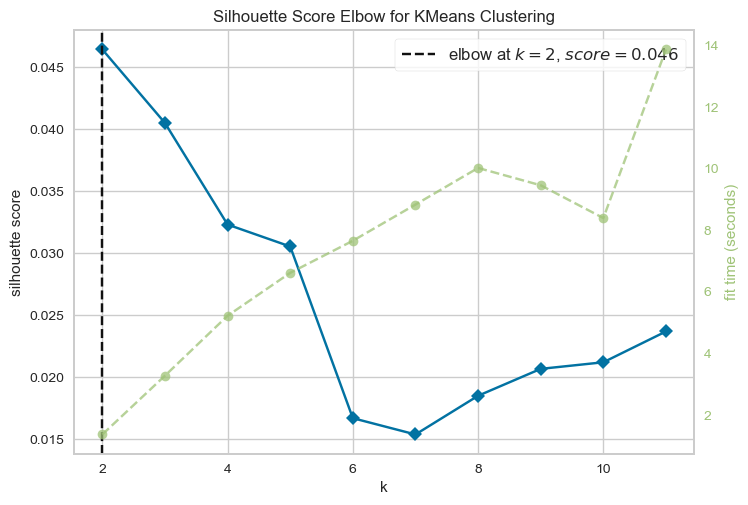

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [31]:
elbow = KElbowVisualizer(kmeans, k=(2, 12), metric='silhouette')
elbow.fit(embeddedSent_df)
elbow.show()

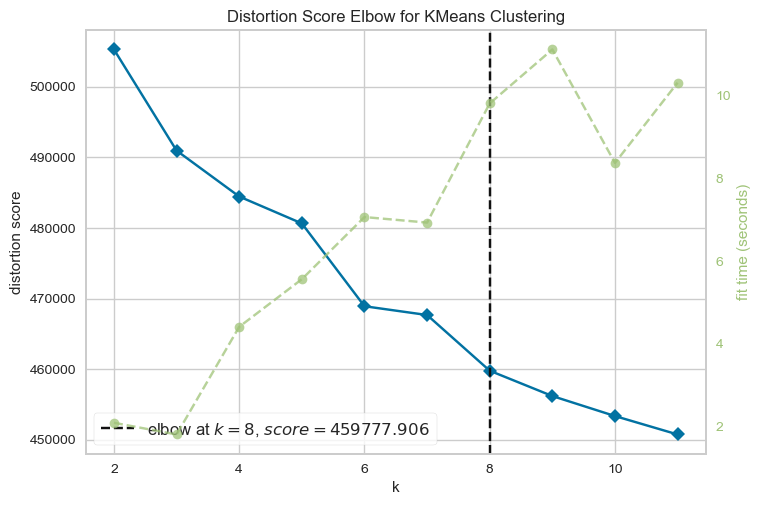

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
elbow = KElbowVisualizer(kmeans, k=(2, 12), metric='distortion')
elbow.fit(embeddedSent_df)
elbow.show()

In [33]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(embeddedSent_df)
kmeans_emb_labels = kmeans.labels_

cluster_df = pd.DataFrame()
cluster_df["emb_kmeans"] = kmeans_emb_labels
display(cluster_df)

,emb_kmeans
0,7
1,7
2,6
3,6
4,0
...,...
14157,4
14158,4
14159,0
14160,4


In [34]:
clusters = cluster_df['emb_kmeans'].nunique()
display(clusters)

8

In [35]:
print_clusters(recipes_df, kmeans_emb_labels, n_recipes=10, replace=False, random_state=None)

Cluster 0
----------
mostaccioli casserole  oamc
champagne cocktail
tgi friday s pot stickers w  dipping sauce
good old gingersnaps
summer heat
nilla wafer martini
vanilla vinaigrette
lemon verbana or lemon balm pesto
aunt bev s hominy
men s pocky



Cluster 1
----------
favorite taco salad
chicken  carrot  and cucumber salad
crunchy vietnamese chicken salad
chicken salad sandwiches
chickpea salad with roasted cumin
potato cobb salad
strawberry romaine salad
moroccan potato salad
1905 salad dressing recipe
orange and date salad  moroccan



Cluster 2
----------
strawberry stripe refrigerator cake
funny bones  cake
karen s chocolate birthday cake
plug s apple hand cake
italian lover s cream cake
orange strawberry shortcake
nutella gooey butter cake
maple syrup layer cake
dark   sumptuous chocolate cake
dark chocolate almond cake with chocolate almond cream cheese fr



Cluster 3
----------
pear and almond swedish pancakes
sweet tea
orange jubilee smoothie
spicy orange ricotta pancakes d

In [36]:
embeddedSent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
42,-0.333474,0.227865,-0.307339,0.410549,0.917103,-0.345506,0.305811,0.256676,-0.147712,0.040728,...,-0.053025,-0.209463,0.362418,-0.246085,0.208379,-0.024874,0.506561,0.197739,-0.386421,-0.002184
101,-0.024523,0.246223,-0.055709,0.358273,0.454786,-0.088054,0.260369,0.231947,0.093013,-0.007835,...,0.144860,-0.435460,0.208344,-0.002655,-0.081200,-0.130489,0.452378,0.186310,-0.278500,0.028580
128,0.029670,0.053190,-0.053991,-0.045817,0.956026,-0.188288,0.071061,-0.025920,-0.167691,0.169709,...,0.023293,0.216612,0.200753,0.271870,-0.023339,0.037475,-0.341244,0.155271,-0.170018,0.012112
129,-0.026562,0.194671,0.038101,-0.099181,0.653784,-0.230868,0.064517,0.001376,-0.061280,0.232094,...,0.169605,0.239355,0.392649,0.271398,-0.093971,0.060101,-0.281418,0.133210,-0.122344,-0.109863
138,-0.168002,-0.219218,0.330761,0.302196,-0.173169,0.204557,0.192390,0.140976,0.303174,0.038062,...,0.019094,-0.002447,0.437832,0.563785,0.033442,0.187658,0.529252,-0.233787,0.509931,0.410714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231539,0.032241,0.358776,0.035928,0.159230,0.446190,0.005988,-0.120629,-0.011145,-0.200737,-0.138867,...,0.129480,-0.087242,0.571369,-0.039195,0.228917,0.307089,0.014226,-0.536662,-0.086178,0.022649
231547,0.016149,-0.053035,-0.035097,-0.021836,0.735161,0.245519,-0.151837,0.003955,0.102566,0.001362,...,0.102296,0.023821,0.602686,-0.067071,0.177534,0.253982,0.242439,-0.436000,-0.053910,0.012423
231596,0.026659,0.202482,0.344634,-0.138708,0.514424,0.630948,-0.003165,-0.102897,-0.434900,-0.192056,...,-0.162457,0.130696,0.113645,0.186651,-0.155393,0.130507,1.146238,-0.240861,0.236831,0.177123
231615,0.140687,-0.218252,-0.230094,-0.359361,0.242314,0.108373,-0.072707,0.346143,-0.026216,0.022497,...,0.567123,-0.017117,0.024793,-0.048090,0.158411,0.287006,0.123452,0.713102,-0.243768,0.409292


<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

### 3.2 DBSCAN
rubric={points:6}

**Your tasks:**

1. Cluster recipe names using `DBSCAN` with `metric="cosine"`. Make some attempts to tune the  hyperparameters `eps` and `min_samples`. 

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 6

DBScan is a challenge to tune. I used kNN as it is a common metric to tune DBScan. The first sharp increase is at around 0.4 or 4/10 distance according to the graph. I tried different min samples, and 0.4 was the trend for all. Next, I tried different values of min samples until I got a lower amount of clusters at 11.  

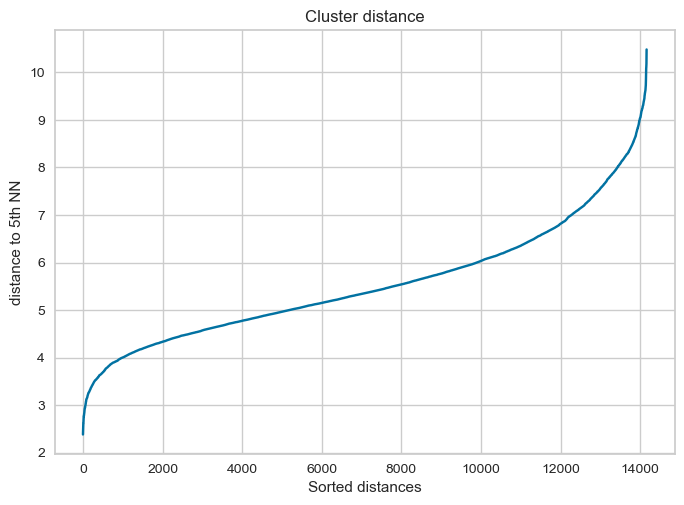

In [37]:
kNN = NearestNeighbors(n_neighbors=5) 
kNN = kNN.fit(embeddedSent_df)  
distance, index = kNN.kneighbors(embeddedSent_df)
distance = np.sort(distance[:, -1], axis=0)

plt.plot(distance)
plt.title('Cluster distance')
plt.xlabel('Sorted distances')
plt.ylabel('distance to 5th NN')
plt.show()

In [38]:
dbscan = DBSCAN(eps=0.4, min_samples=5, metric='cosine')
dbscan_emb_labels = dbscan.fit_predict(embeddedSent_df)
cluster_df["emb_dbscan"] = dbscan_emb_labels
display(cluster_df)

,emb_kmeans,emb_dbscan
0,7,0
1,7,0
2,6,0
3,6,0
4,0,-1
...,...,...
14157,4,0
14158,4,0
14159,0,-1
14160,4,0


In [39]:
clusters = cluster_df['emb_dbscan'].nunique()
display(clusters)

11

In [40]:
print_clusters(recipes_df, dbscan_emb_labels, n_recipes=3, replace=False, random_state=None)

Cluster -1
----------
marshall field s lemon pasta salad
barbeque tofu po boys
hg s 104 calorie creme brulee   ww points   2



Cluster 0
----------
quick and lite chicken quesadillas
ginger plum chicken stir fry
fantastic 3 layer carrot cake



Cluster 1
----------
pam s 7 layer dip
fantastic seven layer dip
7 layer elote dip



Cluster 2
----------
beef bourguignon
boeuf bourguignon  weight watchers
escargots a la bourguignonne



Cluster 3
----------
bourbon sidecar
calvados sidecars
classic sidecar



Cluster 4
----------
lime ginger syrup for fruit salads  weight watchers
weight watchers gob cake
cream cheese strawberry mousse   weight watchers



Cluster 5
----------
a day at the beach
sex on the grass
sex on the beach towel



Cluster 6
----------
ninja and chunky guacamole
best ever chunky guacamole
christina s guacamole



Cluster 7
----------
canadian killer kool aid recipe
killer koolaid
kool aid cocktail



Cluster 8
----------
pollo asado
pollo relleno
puffy relleno



Clu

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Hierarchical clustering
rubric={points:6}

**Your tasks:**

1. Try hierarchical clustering with `metric="cosine"` on this problem. Show a dendrogram by using a suitable truncation method. 
2. Create flat clusters by cutting the tree at the appropriate level. 

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 6

With a large data set, a dendrogram becomes unpractical to use visually to discern clusters. I pruned the tree to the lastp = 12 clusters, so it cut off clusters at the top 12 branches. I tried different values of fcluster, and tried to tune it to around the top branches of the dendrogram. By inspection, the value of 1.12 gave 21 clusters that seem more cohesive in semantics than a lower number of clusters. 

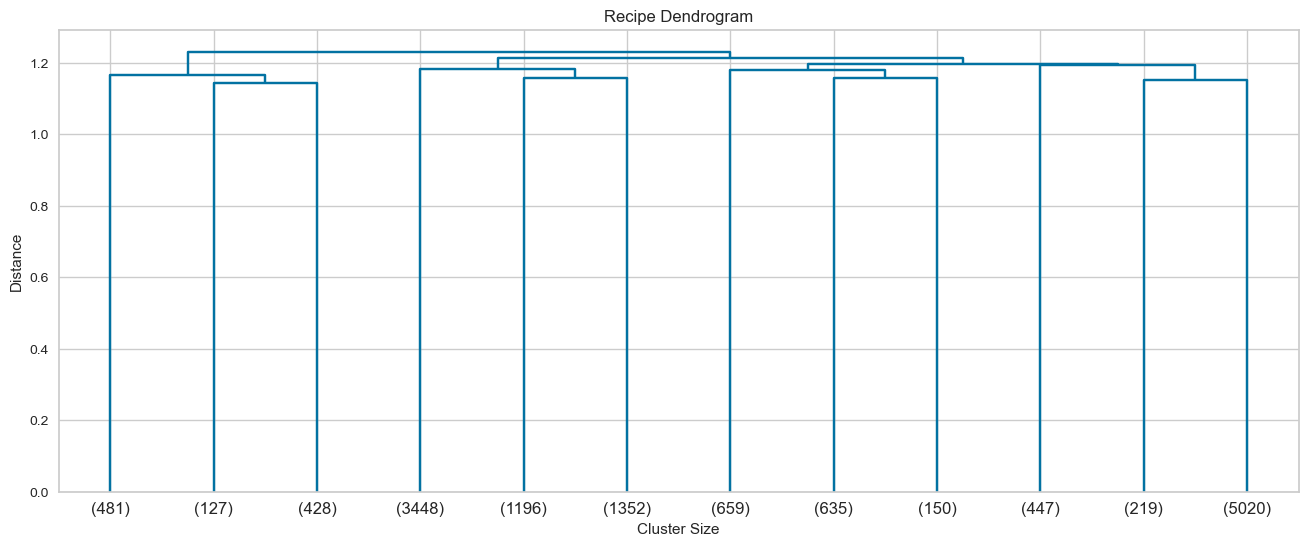

In [41]:
linked = linkage(embeddedSent_df, method='complete', metric='cosine')

plt.figure(figsize=(16,6))

dendrogram(linked, truncate_mode='lastp', p=12)

plt.title('Recipe Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [42]:
hier_emb_labels = fcluster(linked, 1.12, criterion='distance')
#hier_emb_labels = fcluster(linked, 12, criterion="maxclust")

cluster_df["emb_hierarchical"] = hier_emb_labels
display(cluster_df)

,emb_kmeans,emb_dbscan,emb_hierarchical
0,7,0,21
1,7,0,21
2,6,0,20
3,6,0,20
4,0,-1,13
...,...,...,...
14157,4,0,6
14158,4,0,6
14159,0,-1,11
14160,4,0,6


In [43]:
clusters = cluster_df['emb_hierarchical'].nunique()
display(clusters)

21

In [44]:
print_clusters(recipes_df, hier_emb_labels, n_recipes=30, replace=False, random_state=None)

Cluster 1
----------
apple   ricotta slice
karo crazy crunch
spicy orange ricotta pancakes drizzled with rhubarb syrup
coco blossom
orange kissed turnip custards
classic whisky sour
claim jumper s crunchy spinach salad
hearts of romaine  palm   artichoke w  citrus dijon dressing
blueberry scones with lemon glaze
honey puff
cinnamon raisin strata
rich scalloped corn
lemon verbana or lemon balm pesto
pecan muffins in blood orange syrup
blackberry crumble
milk tart with a baked crust
divine cherry coffee
strawberry chutney
carrie s pink blossom
apricot brandy sour
sweet tea mocktail
hearts of palm with lemon dressing
caramel slice squares
lemon berry meringue pie
maple syrup layer cake
raspberry strippers
pear and chocolate crumble
put the lime in the coconut cocktail
banberry surprise
the best frosting i ve ever had



Cluster 2
----------
pear breeze martini
girl scout cookie from 1917
boardwalk breeze
batter
apricot colada alcohol optional
hibiscus jelly
sunstroke
very peary breeze
slu

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Manual interpretation of clusters
rubric={points:6}

**Your tasks:**

1. Label the topics/themes you see in the clusters created by different clustering methods.  
2. Do you see a common theme across clusters created by different clustering methods? Do you see any differences between the clusters created by different clustering methods? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 6

Please note: I changed n_tags to 1000.

    KMeans had 8 clusters with themes of locations (pork chops madrid, vodka Gilligan island), salad, cake, soup, chicken, cookies, baked desserts (buns, muffins, etc). KMeans is a good generalizer, with a lot of these themes also popping up in the WordCloud. 
    The 11 clusters in DBScan had 3 samples each, with themes of dip, bourguignon, sidecar cocktails, weight watchers, sex themed cocktails, guacamole, koolaid, pollo, and another weight watchers. DBScan forms very tight clusters with nuanced topics that other generalist models may not find. 
    For hierarchical clustering, there were 21 clusters, with themes of tart (dessert tarts, lemon flavoured items (semantically tart as well)), fantasy (dragons, unicorn, devil), alcoholic shots and shooters, location (Russian, brussels, commonwealth, French canadian), chicken, Mexican, storms, bread, dip, sexual innuendos, martinis, haystacks and mud, more sexual innuendos, weight watchers, cookies, baked goods, etc. 
    Hierarchical clustering was by far the most creative and entertaining to read. The clusters were very semantically nuanced and developed. To compare and contrast, the bigger picture indicates that KMeans is good for general/average patters, DBScan is good for finding very specific and nuanced, tight themes, while Hierarchical Clustering is good for finding cohesive semantic meaning. It is the most rich and developed model which is expected given that it has the most robust methods of finding clusters (iteratively, and using vector direction).


<!-- END QUESTION -->

<br><br><br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 